In [1]:
import sys
import os
import random
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import json
import seaborn as sns
#from map_utils import *
#from plot_utils import *
import copy
from orderedset import OrderedSet
import DeepTalk_ST as dt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()
adata_sc = sq.datasets.sc_mouse_cortex()

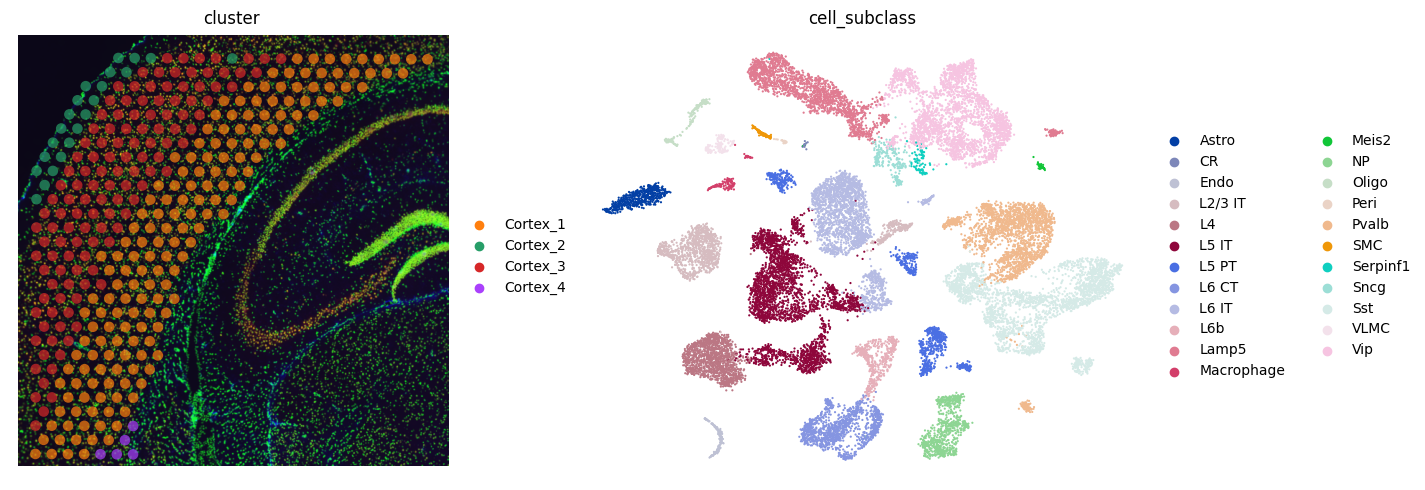

In [3]:
# sc.settings.set_figure_params(figsize=(5, 5), dpi=100)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

In [4]:

adata_sc_raw = copy.deepcopy(adata_sc)
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
adata_st_raw = copy.deepcopy(adata_st)
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)


In [5]:
sq.im.process(img=img, layer="image", method="smooth")

sq.im.segment(
    img=img,
    layer="image_smooth",
    method="watershed",
    channel=0
)

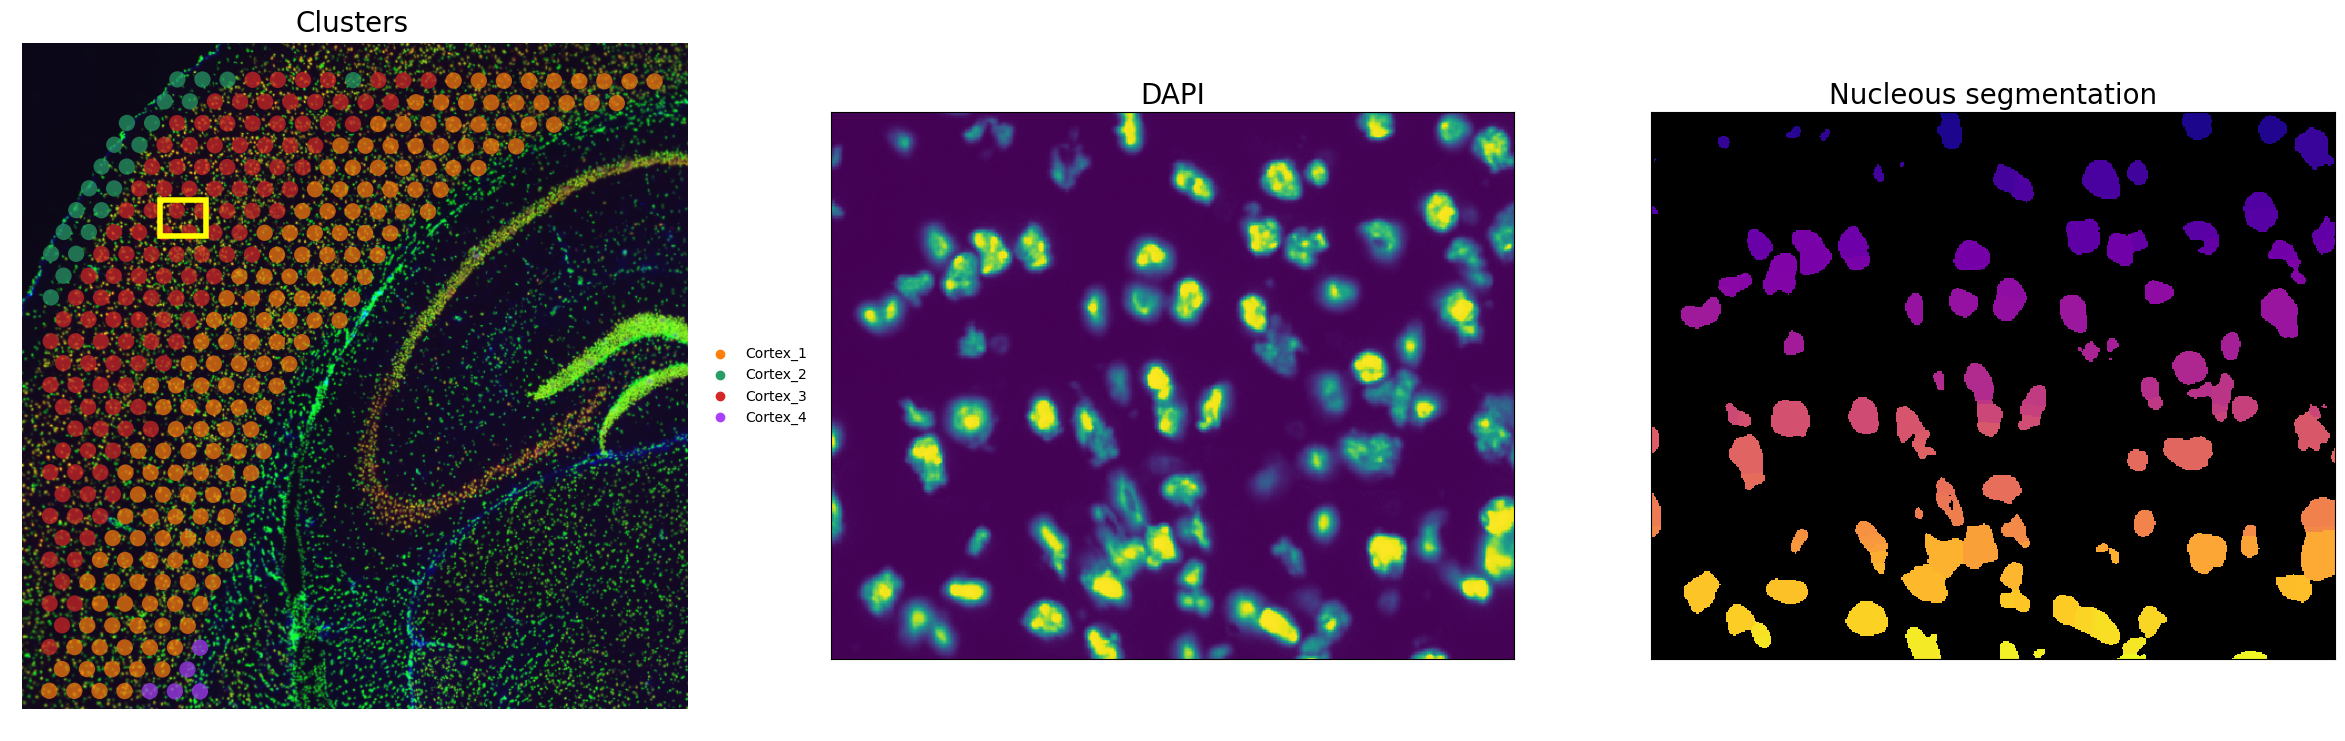

In [6]:
inset_y = 1500
inset_x = 1700
inset_sy = 400
inset_sx = 500

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0], title=""
)
axs[0].set_title("Clusters", fontdict={"fontsize": 20})
sf = adata_st.uns["spatial"]["V1_Adult_Mouse_Brain_Coronal_Section_2"]["scalefactors"][
    "tissue_hires_scalef"
]
rect = mpl.patches.Rectangle(
    (inset_y * sf, inset_x * sf),
    width=inset_sx * sf,
    height=inset_sy * sf,
    ec="yellow",
    lw=4,
    fill=False,
)
axs[0].add_patch(rect)

axs[0].axes.xaxis.label.set_visible(False)
axs[0].axes.yaxis.label.set_visible(False)

axs[1].imshow(
    img["image"][inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx, 0, 0]
    / 65536,
    interpolation="none",
)
axs[1].grid(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("DAPI", fontdict={"fontsize": 20})

crop = img["segmented_watershed"][
    inset_y : inset_y + inset_sy, inset_x : inset_x + inset_sx
].values.squeeze(-1)
crop = skimage.segmentation.relabel_sequential(crop)[0]
cmap = plt.cm.plasma
cmap.set_under(color="black")
axs[2].imshow(crop, interpolation="none", cmap=cmap, vmin=0.001)
axs[2].grid(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Nucleous segmentation", fontdict={"fontsize": 20});

In [7]:
# define image layer to use for segmentation
features_kwargs = {
    "segmentation": {
        "label_layer": "segmented_watershed",
        "props": ["label", "centroid"],
        "channels": [1, 2],
    }
}

sq.im.calculate_image_features(
    adata_st,
    img,
    layer="image",
    key_added="image_features",
    features_kwargs=features_kwargs,
    features="segmentation",
    mask_circle=True,
)

  0%|          | 0/324 [00:00<?, ?/s]

In [11]:
adata_st.obsm['image_features']

segmentation_label  \
AAATGGCATGTCTTGT-1                  13   
AACAACTGGTAGTTGC-1                  15   
AACAGGAAATCGAATA-1                  28   
AACCCAGAGACGGAGA-1                   5   
AACCGTTGTGTTTGCT-1                   7   
...                                ...   
TTGGATTGGGTACCAC-1                  25   
TTGGCTCGCATGAGAC-1                   5   
TTGTATCACACAGAAT-1                  22   
TTGTGGCCCTGACAGT-1                  25   
TTGTTAGCAAATTCGA-1                  27   

                                                segmentation_centroid  
AAATGGCATGTCTTGT-1  [[5304.0, 731.0], [5320.947519118759, 721.3315...  
AACAACTGGTAGTTGC-1  [[1583.0, 4233.828793585227], [1671.5717336342...  
AACAGGAAATCGAATA-1  [[5028.0, 1061.4293230016444], [5042.200781827...  
AACCCAGAGACGGAGA-1  [[1185.0, 1012.0], [1257.9561167460154, 1023.3...  
AACCGTTGTGTTTGCT-1  [[4619.0, 381.72603026366806], [4627.707819057...  
...                                                               ...  
TTGGATTGGGTACCAC-1  [[3379.0, 1609.5027775295625], [3430.128033605...  
TTGGCTCGCATGAGAC-1  [[902.0, 3035.1389252487215], [913.41811041094...  
TTGTATCACACAGAAT-1  [[5992.0, 333.5593226506872], [6001.0050156143...  
TTGTGGCCCTGACAGT-1  [[4064.0, 1794.9633829463617], [4082.278586090...  
TTGTTAGCAAATTCGA-1  [[1589.0, 2787.4719677445705], [1597.800292086...  

[324 rows x 2 columns]

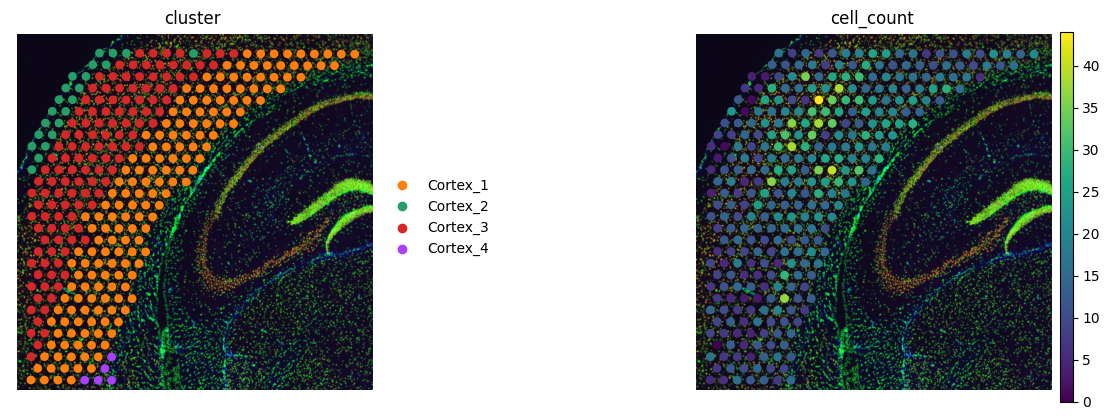

In [9]:
adata_st.obs["cell_count"] = adata_st.obsm["image_features"]["segmentation_label"]
sc.pl.spatial(adata_st, color=["cluster", "cell_count"], frameon=False)
#plt.savefig('/mnt/test/a3/DeepSpa/dataset/mouse_brain/Figure/mouse.pdf',dpi=500)

In [12]:
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
len(markers)

1291

In [13]:
adata_st

AnnData object with n_obs × n_vars = 324 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'cell_count'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial', 'image_features'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
dt.pp_adatas(adata_sc, adata_st, genes=markers)

INFO:root:1187 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [ ]:
ad_map = dt.map_cells_to_space(
    adata_sc=adata_sc,
    adata_sp=adata_st,
    learning_rate=0.0005,
    num_epochs=3000,
    #device='cpu', 
    device='cuda:0',
)

Start training
Epoch 100, Loss: -0.682,Score0: 0.682,Time: 0.989
Epoch 200, Loss: -0.687,Score0: 0.687,Time: 0.996
Epoch 300, Loss: -0.689,Score0: 0.689,Time: 1.003
Epoch 400, Loss: -0.692,Score0: 0.692,Time: 1.004


In [14]:
torch.cuda.empty_cache()

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


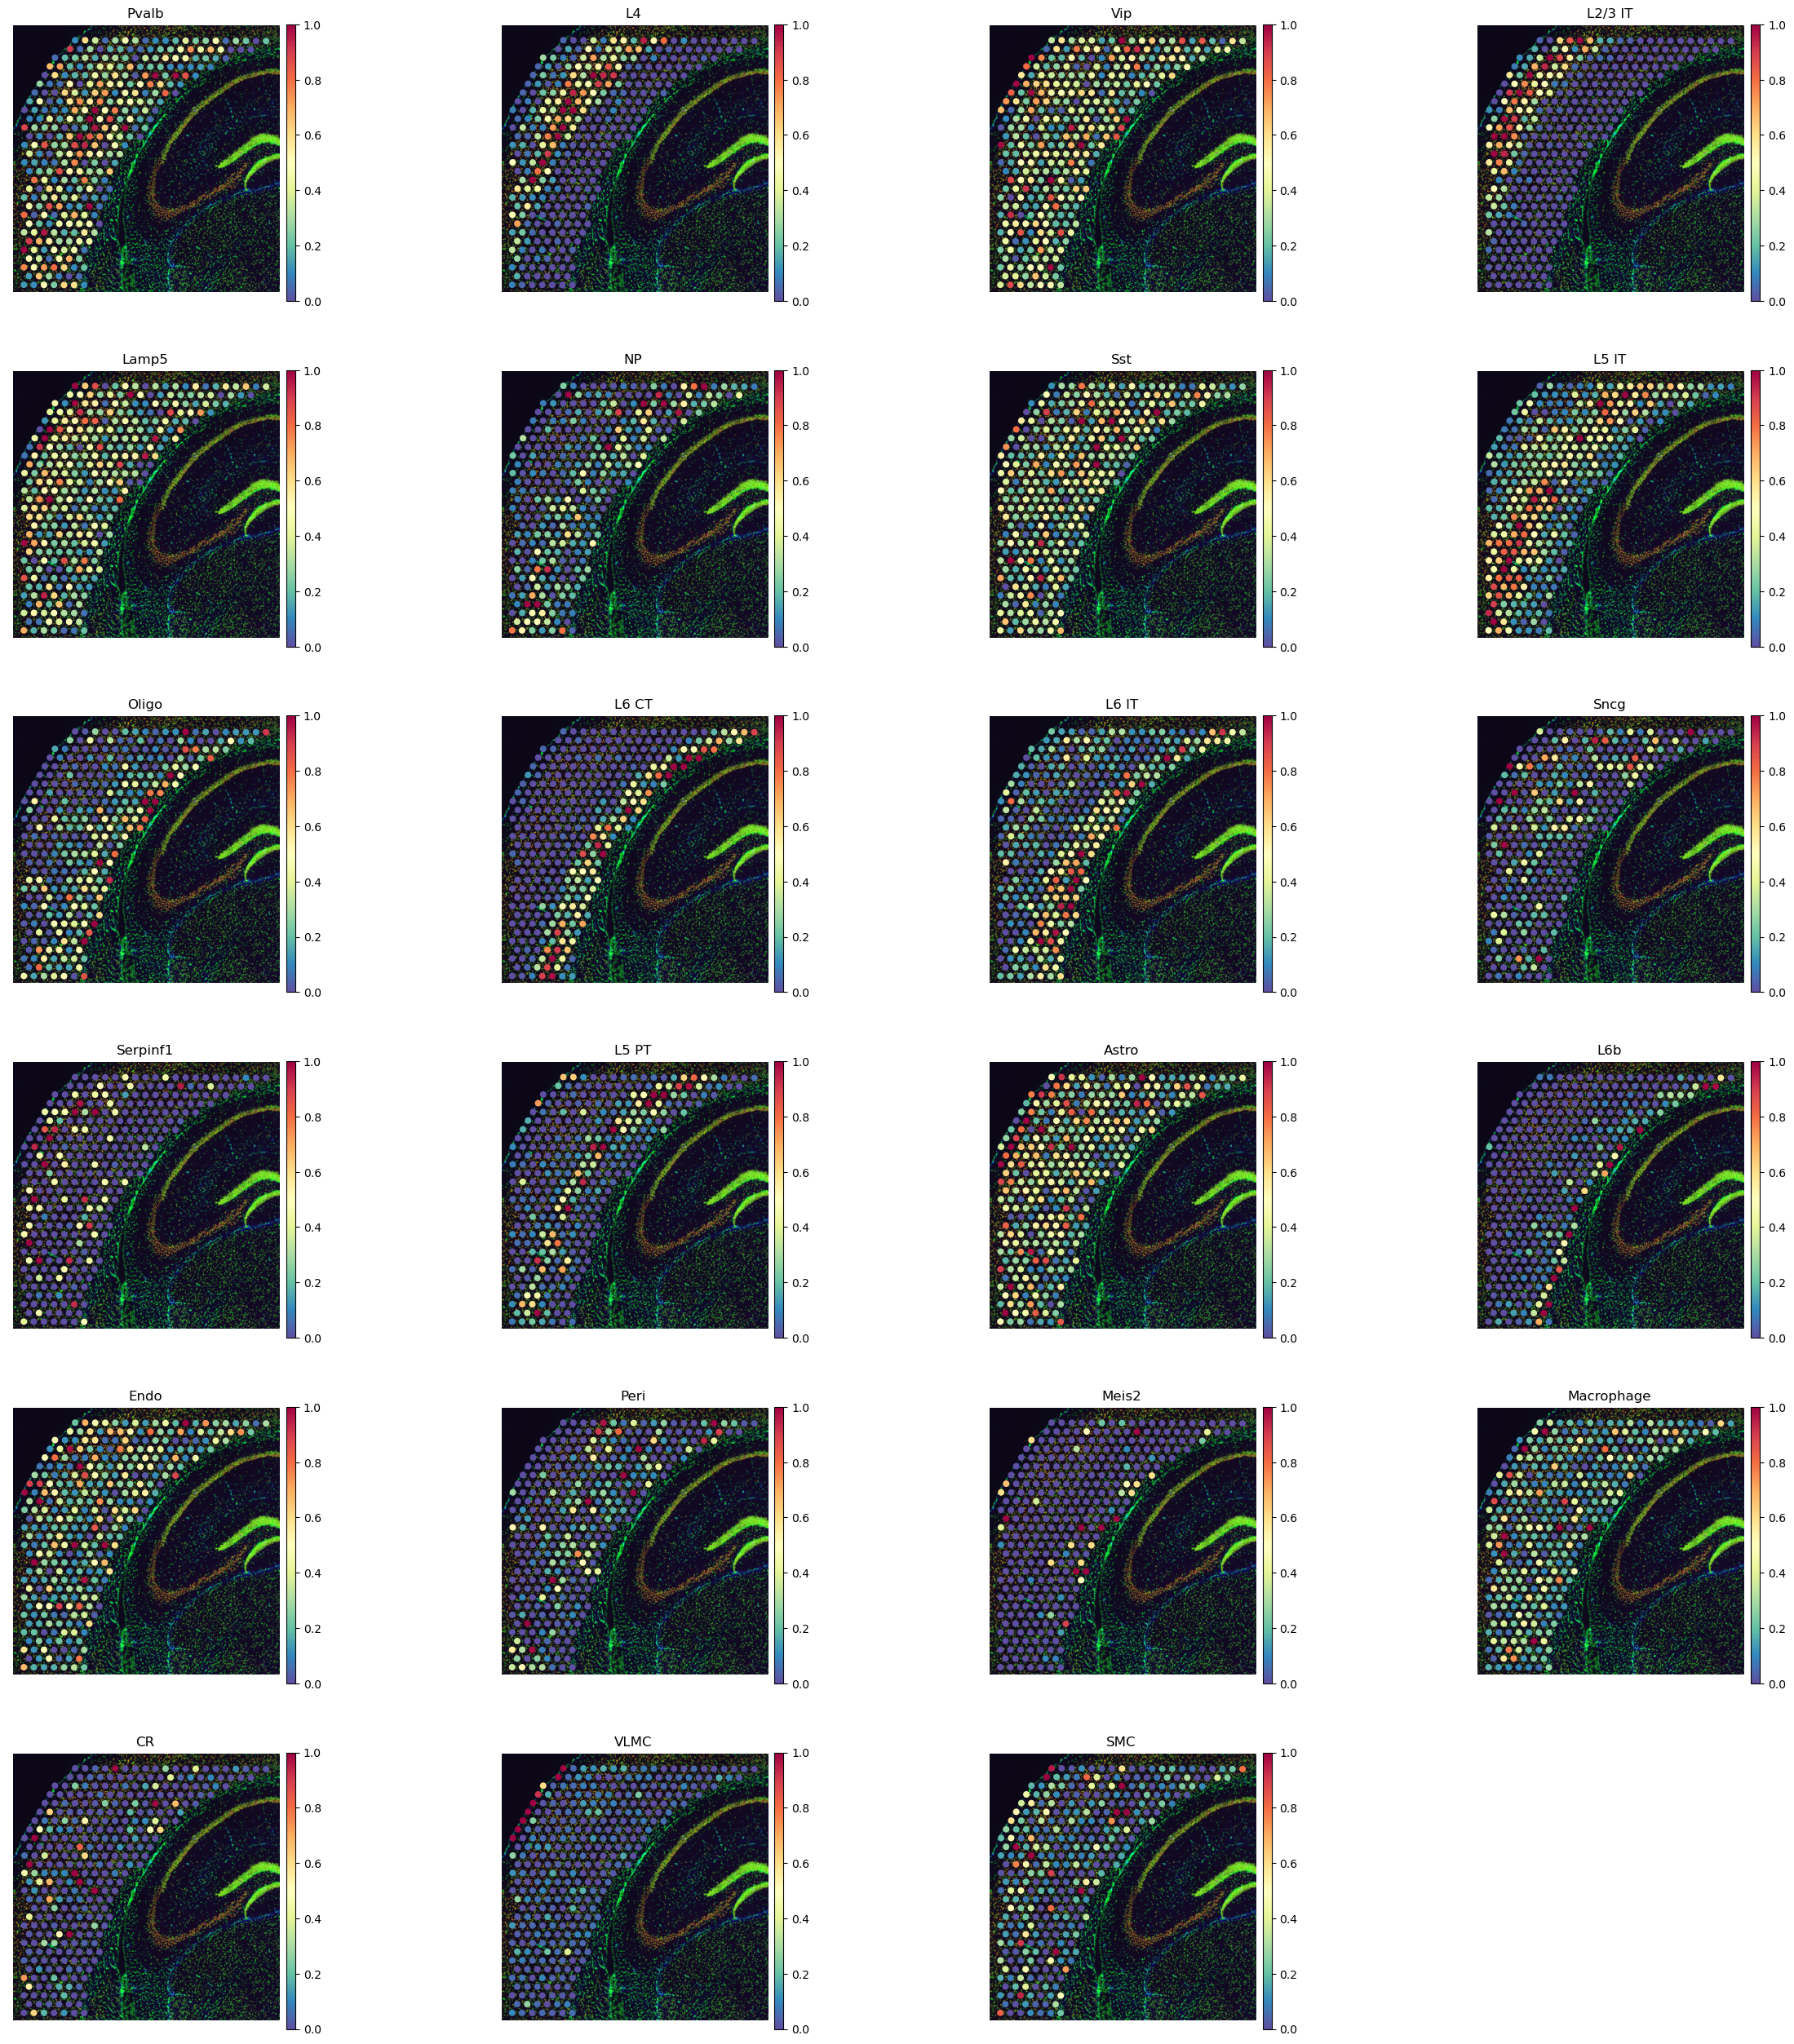

In [16]:
dt.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
dt.plot_cell_annotation_sc1(adata_st, annotation_list,perc=0.02, cmap='Spectral_r', ncols=4,
                           scale_factor=adata_st.uns['spatial']['V1_Adult_Mouse_Brain_Coronal_Section_2']['scalefactors']['tissue_hires_scalef'])

In [17]:
ad_ge = dt.project_genes(adata_map=ad_map, adata_sc=adata_sc)
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'cell_count', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'log1p', 'rank_genes_groups', 'training_genes', 'overlap_genes'

In [18]:
ad_ge.uns['spatial'] = adata_st.uns['spatial'].copy()
ad_ge.obsm['spatial'] = adata_st.obsm['spatial'].copy()

In [19]:
df_all_genes = dt.compare_spatial_geneexp(ad_ge, adata_st, adata_sc)
df_all_genes

score  is_training  sparsity_sp  sparsity_sc  \
ppia           9.972607e-01         True     0.000000     0.000092   
hspa8          9.971285e-01         True     0.000000     0.000784   
gapdh          9.970894e-01         True     0.000000     0.000968   
snap25         9.970045e-01         True     0.000000     0.014610   
ubb            9.968820e-01         True     0.000000     0.000092   
...                     ...          ...          ...          ...   
6330420h09rik  6.179793e-08        False     0.996914     0.998894   
kcnk5          2.806382e-08        False     0.996914     0.998894   
chil3          1.095858e-08        False     0.996914     0.998894   
sntn           1.149578e-09        False     0.996914     0.999493   
klk1           2.061481e-10        False     0.996914     0.999539   

               sparsity_diff  
ppia               -0.000092  
hspa8              -0.000784  
gapdh              -0.000968  
snap25             -0.014610  
ubb                -0.000092  
...                      ...  
6330420h09rik      -0.001980  
kcnk5              -0.001980  
chil3              -0.001980  
sntn               -0.002579  
klk1               -0.002626  

[14785 rows x 5 columns]

In [20]:
adata_st.obsm['tangram_ct_pred']

Pvalb            L4        Vip       L2/3 IT  \
AAATGGCATGTCTTGT-1  12.254452  5.132943e-07   4.466996  1.701229e-06   
AACAACTGGTAGTTGC-1   3.506396  1.105901e-03  20.112390  3.267677e-04   
AACAGGAAATCGAATA-1   2.452892  3.072844e-03   5.545910  3.136249e-07   
AACCCAGAGACGGAGA-1  13.237399  3.005946e+00   7.731059  4.013486e+00   
AACCGTTGTGTTTGCT-1   7.108975  9.462023e-03   6.718724  1.892558e-02   
...                       ...           ...        ...           ...   
TTGGATTGGGTACCAC-1   9.305740  7.014791e-03   7.591663  2.364912e-03   
TTGGCTCGCATGAGAC-1   0.133254  7.794385e+00   4.783985  1.966391e+01   
TTGTATCACACAGAAT-1   5.138725  3.202729e-03   4.601352  4.943360e-07   
TTGTGGCCCTGACAGT-1  15.088356  3.507979e-03   3.004911  1.614658e-02   
TTGTTAGCAAATTCGA-1   0.953884  2.941663e+01   3.098423  1.006796e+00   

                        Lamp5        NP        Sst      L5 IT     Oligo  \
AAATGGCATGTCTTGT-1   5.842616  1.023512   7.699689   7.346015  0.010030   
AACAACTGGTAGTTGC-1   5.245172  3.661193   2.391880  11.746488  0.112219   
AACAGGAAATCGAATA-1  11.398148  0.015161   5.169364   3.122062  0.564583   
AACCCAGAGACGGAGA-1   6.967136  0.014710   5.897280  12.258893  0.211953   
AACCGTTGTGTTTGCT-1   1.673623  0.007092   6.522557  17.421520  2.725875   
...                       ...       ...        ...        ...       ...   
TTGGATTGGGTACCAC-1   4.445598  1.725376  14.719877  11.563809  0.468560   
TTGGCTCGCATGAGAC-1   6.963077  0.000254   7.474484   3.993198  0.001972   
TTGTATCACACAGAAT-1   5.280989  3.308721   7.873294   8.435636  0.348486   
TTGTGGCCCTGACAGT-1   2.005873  0.008214   4.258130   3.021235  1.777900   
TTGTTAGCAAATTCGA-1   3.852289  0.551590  13.230791   7.769339  0.513157   

                           L6 CT  ...     L5 PT     Astro           L6b  \
AAATGGCATGTCTTGT-1  5.015769e+00  ...  6.601109  3.814662  3.088395e-02   
AACAACTGGTAGTTGC-1  1.025299e+00  ...  6.875342  1.968809  1.327440e+00   
AACAGGAAATCGAATA-1  2.264106e+01  ...  0.001560  1.916585  1.518425e+00   
AACCCAGAGACGGAGA-1  6.578483e-07  ...  0.558902  2.420343  7.400525e-09   
AACCGTTGTGTTTGCT-1  3.038468e-01  ...  2.886608  0.713764  5.003909e-07   
...                          ...  ...       ...       ...           ...   
TTGGATTGGGTACCAC-1  3.616983e-03  ...  7.470689  2.938970  1.540710e-03   
TTGGCTCGCATGAGAC-1  4.410283e-05  ...  0.018504  0.081348  1.628786e-04   
TTGTATCACACAGAAT-1  7.335908e+00  ...  1.412773  0.572385  9.385166e-01   
TTGTGGCCCTGACAGT-1  2.017276e+00  ...  1.997785  1.998778  2.342876e+00   
TTGTTAGCAAATTCGA-1  7.002517e-06  ...  0.001729  1.351792  4.445984e-04   

                        Endo      Peri         Meis2  Macrophage        CR  \
AAATGGCATGTCTTGT-1  0.313026  0.000372  1.574809e-04    1.044404  0.042176   
AACAACTGGTAGTTGC-1  0.201051  0.117679  9.982840e-01    0.697289  0.009623   
AACAGGAAATCGAATA-1  0.205977  0.222628  6.523239e-03    0.441351  0.012499   
AACCCAGAGACGGAGA-1  0.658679  0.001059  6.140609e-06    1.925095  0.002181   
AACCGTTGTGTTTGCT-1  3.660062  0.013709  4.186649e-04    0.516594  0.001518   
...                      ...       ...           ...         ...       ...   
TTGGATTGGGTACCAC-1  0.799469  0.003381  8.965274e-07    0.098873  0.000576   
TTGGCTCGCATGAGAC-1  0.326770  0.000457  1.196504e-04    0.132690  0.000048   
TTGTATCACACAGAAT-1  0.254729  0.165535  1.521373e-04    0.138985  0.055351   
TTGTGGCCCTGACAGT-1  0.463684  0.066018  3.901836e-03    0.961492  0.001633   
TTGTTAGCAAATTCGA-1  0.645988  0.088050  1.512020e-05    0.153568  0.001246   

                        VLMC       SMC  
AAATGGCATGTCTTGT-1  0.095789  0.525870  
AACAACTGGTAGTTGC-1  0.005300  1.368797  
AACAGGAAATCGAATA-1  0.025626  0.001198  
AACCCAGAGACGGAGA-1  0.834848  0.299725  
AACCGTTGTGTTTGCT-1  0.008013  0.331701  
...                      ...       ...  
TTGGATTGGGTACCAC-1  0.294103  1.719901  
TTGGCTCGCATGAGAC-1  0.041548  0.782798  
TTGTATCACACAGAAT-1  0.121819  0.007479  
TTGTGGCCCT

In [21]:
dt.create_segment_cell_df(adata_st)
adata_st.uns["tangram_cell_segmentation"]

spot_idx            y            x              centroids
0     AAATGGCATGTCTTGT-1  5304.000000   731.000000   AAATGGCATGTCTTGT-1_0
1     AAATGGCATGTCTTGT-1  5320.947519   721.331554   AAATGGCATGTCTTGT-1_1
2     AAATGGCATGTCTTGT-1  5332.942342   717.447904   AAATGGCATGTCTTGT-1_2
3     AAATGGCATGTCTTGT-1  5348.865384   558.924248   AAATGGCATGTCTTGT-1_3
4     AAATGGCATGTCTTGT-1  5342.124989   567.208502   AAATGGCATGTCTTGT-1_4
...                  ...          ...          ...                    ...
5134  TTGTTAGCAAATTCGA-1  1738.031111  2798.802672  TTGTTAGCAAATTCGA-1_22
5135  TTGTTAGCAAATTCGA-1  1763.084642  2732.021185  TTGTTAGCAAATTCGA-1_23
5136  TTGTTAGCAAATTCGA-1  1761.129565  2722.866980  TTGTTAGCAAATTCGA-1_24
5137  TTGTTAGCAAATTCGA-1  1763.481302  2813.403047  TTGTTAGCAAATTCGA-1_25
5138  TTGTTAGCAAATTCGA-1  1768.000000  2777.945307  TTGTTAGCAAATTCGA-1_26

[5139 rows x 4 columns]

In [22]:
dt.count_cell_annotations(
    ad_map,
    adata_sc,
    adata_st,
    annotation="cell_subclass",
)
adata_st.obsm["tangram_ct_count"]

x     y  cell_n  \
AAATGGCATGTCTTGT-1   641  5393      13   
AACAACTGGTAGTTGC-1  4208  1672      16   
AACAGGAAATCGAATA-1  1117  5117      28   
AACCCAGAGACGGAGA-1  1101  1274       5   
AACCGTTGTGTTTGCT-1   399  4708       7   
...                  ...   ...     ...   
TTGGATTGGGTACCAC-1  1588  3468      26   
TTGGCTCGCATGAGAC-1  3011   991       5   
TTGTATCACACAGAAT-1   405  6081      22   
TTGTGGCCCTGACAGT-1  1830  4153      25   
TTGTTAGCAAATTCGA-1  2775  1678      27   

                                                            centroids  Pvalb  \
AAATGGCATGTCTTGT-1  [AAATGGCATGTCTTGT-1_0, AAATGGCATGTCTTGT-1_1, A...      3   
AACAACTGGTAGTTGC-1  [AACAACTGGTAGTTGC-1_0, AACAACTGGTAGTTGC-1_1, A...      1   
AACAGGAAATCGAATA-1  [AACAGGAAATCGAATA-1_0, AACAGGAAATCGAATA-1_1, A...      1   
AACCCAGAGACGGAGA-1  [AACCCAGAGACGGAGA-1_0, AACCCAGAGACGGAGA-1_1, A...      8   
AACCGTTGTGTTTGCT-1  [AACCGTTGTGTTTGCT-1_0, AACCGTTGTGTTTGCT-1_1, A...      4   
...                                                               ...    ...   
TTGGATTGGGTACCAC-1  [TTGGATTGGGTACCAC-1_0, TTGGATTGGGTACCAC-1_1, T...      3   
TTGGCTCGCATGAGAC-1  [TTGGCTCGCATGAGAC-1_0, TTGGCTCGCATGAGAC-1_1, T...      0   
TTGTATCACACAGAAT-1  [TTGTATCACACAGAAT-1_0, TTGTATCACACAGAAT-1_1, T...      2   
TTGTGGCCCTGACAGT-1  [TTGTGGCCCTGACAGT-1_0, TTGTGGCCCTGACAGT-1_1, T...      9   
TTGTTAGCAAATTCGA-1  [TTGTTAGCAAATTCGA-1_0, TTGTTAGCAAATTCGA-1_1, T...      0   

                    L4  Vip  L2/3 IT  Lamp5  NP  ...  L5 PT  Astro  L6b  Endo  \
AAATGGCATGTCTTGT-1   0    3        0      1   1  ...      3      1    0     0   
AACAACTGGTAGTTGC-1   0    2        0      3   3  ...      1      2    0     0   
AACAGGAAATCGAATA-1   0    1        0      4   0  ...      0      0    1     0   
AACCCAGAGACGGAGA-1   2    6        3      3   0  ...      1      2    0     1   
AACCGTTGTGTTTGCT-1   0    2        0      2   0  ...      3      1    0     0   
...                 ..  ...      ...    ...  ..  ...    ...    ...  ...   ...   
TTGGATTGGGTACCAC-1   0    4        0      4   1  ...      3      1    0     0   
TTGGCTCGCATGAGAC-1   2    2        7      3   0  ...      0      0    0     0   
TTGTATCACACAGAAT-1   0    1        0      3   2  ...      1      0    0     0   
TTGTGGCCCTGACAGT-1   0    1        0      0   0  ...      1      2    1     1   
TTGTTAGCAAATTCGA-1  16    2        0      4   1  ...      0      1    0     0   

                    Peri  Meis2  Macrophage  CR  VLMC  SMC  
AAATGGCATGTCTTGT-1     0      0           2   0     0    1  
AACAACTGGTAGTTGC-1     0      1           0   0     0    0  
AACAGGAAATCGAATA-1     0      0           0   0     0    0  
AACCCAGAGACGGAGA-1     0      0           0   0     0    0  
AACCGTTGTGTTTGCT-1     0      0           1   0     0    1  
...                  ...    ...         ...  ..   ...  ...  
TTGGATTGGGTACCAC-1     0      0           0   0     0    1  
TTGGCTCGCATGAGAC-1     0      0           0   0     0    1  
TTGTATCACACAGAAT-1     0      0           0   0     0    0  
TTGTGGCCCTGACAGT-1     0      0           1   0     0    0  
TTGTTAGCAAATTCGA-1     0      0           0   0     0    0  

[324 rows x 27 columns]

In [23]:
adata_segment = dt.deconvolve_cell_annotations(adata_st)

adata_segment.obs

y            x              centroids cluster
0     5304.000000   731.000000   AAATGGCATGTCTTGT-1_0   Pvalb
1     5320.947519   721.331554   AAATGGCATGTCTTGT-1_1   Pvalb
2     5332.942342   717.447904   AAATGGCATGTCTTGT-1_2   Pvalb
3     5348.865384   558.924248   AAATGGCATGTCTTGT-1_3     Vip
4     5342.124989   567.208502   AAATGGCATGTCTTGT-1_4     Vip
...           ...          ...                    ...     ...
5073  1738.031111  2798.802672  TTGTTAGCAAATTCGA-1_22      NP
5074  1763.084642  2732.021185  TTGTTAGCAAATTCGA-1_23     Sst
5075  1761.129565  2722.866980  TTGTTAGCAAATTCGA-1_24     Sst
5076  1763.481302  2813.403047  TTGTTAGCAAATTCGA-1_25     Sst
5077  1768.000000  2777.945307  TTGTTAGCAAATTCGA-1_26     Sst

[5078 rows x 4 columns]

In [24]:
adata_segment

AnnData object with n_obs × n_vars = 5078 × 4
    obs: 'y', 'x', 'centroids', 'cluster'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap', 'log1p', 'training_genes', 'overlap_genes', 'tangram_cell_segmentation'
    obsm: 'spatial'

In [25]:
adata_segment.uns['tangram_cell_segmentation']

spot_idx            y            x              centroids
0     AAATGGCATGTCTTGT-1  5304.000000   731.000000   AAATGGCATGTCTTGT-1_0
1     AAATGGCATGTCTTGT-1  5320.947519   721.331554   AAATGGCATGTCTTGT-1_1
2     AAATGGCATGTCTTGT-1  5332.942342   717.447904   AAATGGCATGTCTTGT-1_2
3     AAATGGCATGTCTTGT-1  5348.865384   558.924248   AAATGGCATGTCTTGT-1_3
4     AAATGGCATGTCTTGT-1  5342.124989   567.208502   AAATGGCATGTCTTGT-1_4
...                  ...          ...          ...                    ...
5134  TTGTTAGCAAATTCGA-1  1738.031111  2798.802672  TTGTTAGCAAATTCGA-1_22
5135  TTGTTAGCAAATTCGA-1  1763.084642  2732.021185  TTGTTAGCAAATTCGA-1_23
5136  TTGTTAGCAAATTCGA-1  1761.129565  2722.866980  TTGTTAGCAAATTCGA-1_24
5137  TTGTTAGCAAATTCGA-1  1763.481302  2813.403047  TTGTTAGCAAATTCGA-1_25
5138  TTGTTAGCAAATTCGA-1  1768.000000  2777.945307  TTGTTAGCAAATTCGA-1_26

[5139 rows x 4 columns]

In [26]:
mapping_colors = {
    "L6 CT": (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
    "L6 IT": (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
    "NP": (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
    "L6b": "#0000c2ff",
    "L2/3 IT": "#a1ed7bff",
    "L5 IT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 ET": (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
    "Oligo": (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
    "Vip": (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
    "Astro": "#ffdd55ff",
    "L6 CT": "#000000ff",
    "Pvalb": (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
    "Lamp5": (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
    "Sst": (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
    "CR": (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
    "Sncg": (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
    "Peri": (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
    "VLMC": (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
    "Endo": (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
    "Meis2": "#FFA500ff",
    "SMC": "#000000ff",
    "L6 PT": "#4682B4ff",
    "L5 PT": (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
    "L5 NP": "#6B8E23ff",
    "L4": "#d61f1dff",
    "Macrophage": "#2b2d2fff",
    "Serpinf1": "#000000ff",
}

In [27]:
cluster = adata_segment.obs['cluster'].values
color_list = []
for i in range(len(list(cluster))):
    color_list.append(mapping_colors[list(cluster)[i]])

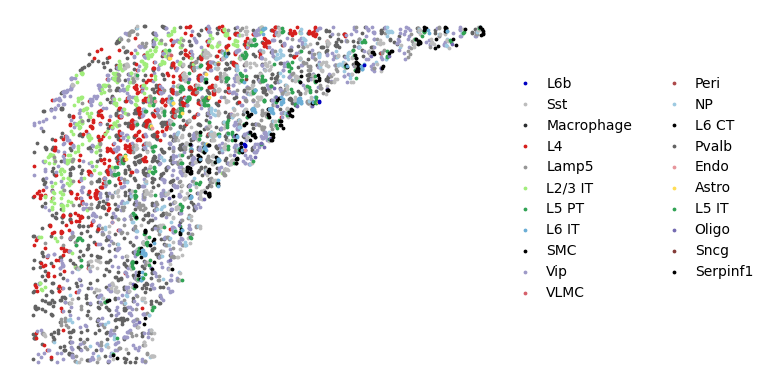

In [28]:
x = adata_segment.obs.x.values
y = adata_segment.obs.y.values
plt.axis('off')
for x_val, y_val, color_val,g in zip(x, y, color_list,list(cluster)):
    plt.scatter(y_val,x_val,color=color_val,s=3,label=g)
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles,unique_labels,loc=(1,0.2),fontsize = 10,ncol =2,frameon=False,handlelength=2, handletextpad=0.5)
plt.gca().invert_yaxis()
#plt.savefig('/mnt/test/a3/DeepSpa/dataset/mouse_brain/figures/Brain_all.pdf',bbox_inches='tight',dpi=300)

In [29]:
adata_segment.obs.to_csv('./spot/st_obs.csv')
adata_sc.obs.to_csv('./spot/sc_obs.csv')

In [30]:
index1 = [word.capitalize() for word in adata_sc.var.index]
c_list = [f'C{i}' for i in range(1, adata_sc.X.shape[0]+1)]
df = pd.DataFrame(adata_sc.X.T,index=index1,columns=c_list)
df.to_csv('./spot/ad_sc.csv')

In [31]:
index1 = [word.capitalize() for word in ad_ge.var.index]
c_list = [word.capitalize() for word in ad_ge.obs.index]
df = pd.DataFrame(ad_ge.X.T,index=index1,columns=c_list)
df.to_csv('./spot/ad_ge.csv')
ad_ge

AnnData object with n_obs × n_vars = 324 × 36826
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'cell_count', 'uniform_density', 'rna_count_based_density'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'sparsity', 'is_training'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap', 'log1p', 'rank_genes_groups', 'training_genes', 'overlap_genes', 'spatial'
    obsm: 'spatial'

In [32]:
os.chdir("./spot")

In [33]:
#Rscript prepro.R  #生成
#os.chdir("./spot")
import subprocess
r_script_file = './prepro.R'

# 运行R脚本
process = subprocess.Popen(['Rscript', r_script_file], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
process.communicate()




('Generating single-cell data for each spot \n', '')

In [34]:
lrpairs = pd.read_csv('../lrpairs_new.csv')
lr_all_human = lrpairs.iloc[0:4715,:].ligand.unique().tolist()+lrpairs.iloc[0:4715,:].receptor.unique().tolist()
lr_all_human_new = list(set(lr_all_human))

lr_all_mouse = lrpairs.iloc[4715:,:].ligand.unique().tolist()+lrpairs.iloc[0:4715,:].receptor.unique().tolist()
lr_all_mouse_new = list(set(lr_all_mouse))
tf = pd.read_csv('../df_pathways.csv')
tf_human = tf.iloc[0:370593,:].src.unique().tolist()+tf.iloc[0:370593,:].dest.unique().tolist()
tf_human_new = list(set(tf_human))

tf_mouse = tf.iloc[370593:,:].src.unique().tolist()+tf.iloc[0:370593,:].dest.unique().tolist()
tf_mouse_new = list(set(tf_mouse))

gene_all_mouse=list(set(tf_mouse_new + lr_all_mouse_new))
gene_all_human=list(set(tf_human_new + lr_all_human_new))

In [35]:
newdata = pd.read_csv('./newdata.csv',index_col=0)
newadata = sc.AnnData(newdata.T)
newadata

AnnData object with n_obs × n_vars = 5078 × 36826

In [36]:
newadata

AnnData object with n_obs × n_vars = 5078 × 36826

In [37]:
newadata1 = copy.deepcopy(newadata)
sc.pp.filter_cells(newadata1, min_genes=200)
sc.pp.filter_genes(newadata1, min_cells=3)
sc.pp.filter_genes_dispersion(newadata1,flavor='cell_ranger', log=False)
newadata1 = newadata1[:, newadata1.X.mean(axis=0) >= 0.5]
newadata1

View of AnnData object with n_obs × n_vars = 5078 × 6234
    obs: 'n_genes'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm'

In [38]:
index1 = [word.capitalize() for word in newadata1.var.index]
c_list = [f'C{i}' for i in range(1, newadata1.X.shape[0]+1)]
df = pd.DataFrame(newadata1.X.T,index=index1,columns=c_list)
df = df[df.index.isin(gene_all_mouse)]
df.to_csv('./ad_st_new.csv',float_format='%.2f')
df

C1        C2        C3        C4        C5        C6        C7  \
Aaas    1.283585  1.607389  1.874692  0.618724  0.000000  1.547840  1.804680   
Aacs    1.465627  1.737743  1.138337  1.773619  0.000000  1.471761  0.000000   
Abcb6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.859063   
Abcb8   0.985895  1.374771  1.138337  0.000000  0.928934  1.678766  1.871120   
Abcc5   1.649280  1.601589  1.691289  1.737224  1.640733  1.780402  2.010000   
...          ...       ...       ...       ...       ...       ...       ...   
Zdhhc8  0.000000  1.473886  1.763048  1.777878  1.177735  0.000000  1.662755   
Zfand6  1.744415  1.773753  1.910095  1.941937  1.973155  1.848987  1.848014   
Znrf1   1.647847  1.635137  1.802200  1.616947  1.280746  1.096578  0.000000   
Znrf2   1.210251  0.000000  0.000000  1.478092  0.835518  1.096578  1.167246   
Zw10    0.000000  1.663981  0.000000  1.769237  0.000000  0.000000  1.843779   

              C8        C9       C10  ...     C5069     C5070     C5071  \
Aaas    1.498950  0.000000  1.789122  ...  0.000000  0.000000  1.051843   
Aacs    1.683706  1.436112  1.792013  ...  1.965062  0.000000  1.656610   
Abcb6   0.000000  0.000000  1.873902  ...  0.000000  1.769924  1.677732   
Abcb8   1.547957  0.453927  0.000000  ...  1.704980  1.823491  0.796327   
Abcc5   1.718547  1.643407  1.550940  ...  1.807293  0.701243  1.613445   
...          ...       ...       ...  ...       ...       ...       ...   
Zdhhc8  1.340142  1.447152  0.000000  ...  0.000000  1.703824  1.485321   
Zfand6  1.897213  1.636855  2.020736  ...  1.915955  1.810135  1.750430   
Znrf1   1.480491  1.536883  1.898158  ...  0.000000  0.000000  1.672718   
Znrf2   0.951604  0.000000  1.749477  ...  0.000000  0.000000  0.670075   
Zw10    1.537859  1.568390  1.370760  ...  0.000000  1.760340  0.464428   

           C5072     C5073     C5074     C5075     C5076     C5077     C5078  
Aaas    1.798674  1.721202  1.871480  1.550888  1.511271  1.597623  1.482678  
Aacs    0.000000  1.610869  0.000000  1.701958  1.793347  1.410200  1.688884  
Abcb6   1.451646  0.000000  0.000000  1.606208  0.000000  0.000000  1.666654  
Abcb8   1.602739  0.000000  0.000000  0.000000  1.506100  1.498081  1.659638  
Abcc5   1.819550  1.710305  2.085989  1.241133  1.457827  1.799221  1.740351  
...          ...       ...       ...       ...       ...       ...       ...  
Zdhhc8  1.475296  1.399831  0.000000  0.535859  1.506100  0.740810  0.000000  
Zfand6  1.369292  1.834642  2.017406  1.806089  1.713962  1.807655  1.773131  
Znrf1   0.000000  1.558310  1.849892  1.539446  1.662372  1.675600  1.471555  
Znrf2   0.000000  1.445583  0.000000  1.309321  1.435573  1.524186  1.620967  
Zw10    1.616612  1.790997  0.000000  0.742160  1.557565  0.000000  1.673355  

[1978 rows x 5078 columns]

In [39]:
#os.chdir("./spot")


In [40]:
#Rscript process.R  #生成
import subprocess
r_script_file = './process.R'

# 运行R脚本
process = subprocess.Popen(['Rscript', r_script_file], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
process.communicate()



#Rscript process.R  #生成Cell_pair

('Checking input data \nBegin to filter lrpairs and pathways \n***Done*** \nNote: there are 21 cell types and 420 pair-wise cell pairs \nBegin to find LR pairs \n',
 '')

In [41]:
import sys
import numpy as np
import pandas as pd
import os
import random
import shutil
from orderedset import OrderedSet
import json

df = pd.read_csv('./ad_st_new.csv',index_col=0)

lrpairs = pd.read_csv('./lrpairs.csv')
lrpairs_ligand = lrpairs["ligand"]
lrpairs_receptor = lrpairs["receptor"]
cci_dict = {}
#len(lrpairs_ligand)
for ii in range(len(lrpairs_ligand)):
    #print(lrpairs_ligand[ii])

    Cellpairall = pd.read_csv('./cell_pair_all.csv')
    ligand = Cellpairall["ligand"]
    receptor = Cellpairall["receptor"]
    Sender = Cellpairall["cell_sender"]
    Receiver = Cellpairall["cell_receiver"]
    CCIlabel = Cellpairall["label"]
    cell_pair_label = []
    
    for i in range(len(Sender)):
        if ligand[i]==lrpairs_ligand[ii] and receptor[i]==lrpairs_receptor[ii]:
            if df.loc[lrpairs_ligand[ii],str(Sender[i])]>0.1 and df.loc[lrpairs_receptor[ii],str(Receiver[i])]>0.1:
                score = np.sqrt(df.loc[lrpairs_ligand[ii],str(Sender[i])]*df.loc[lrpairs_receptor[ii],str(Receiver[i])])
                #print(score)
                cell_pair_label.append([Sender[i],Receiver[i],str(score),str(CCIlabel[i])])
            else:
                score = np.sqrt(df.loc[lrpairs_ligand[ii],str(Sender[i])]*df.loc[lrpairs_receptor[ii],str(Receiver[i])])
                cell_pair_label.append([Sender[i],Receiver[i],str(score),'0'])
    cell_pair = []
    for i in range(len(Sender)):
        if df.loc[lrpairs_ligand[ii],str(Sender[i])]>0 and df.loc[lrpairs_receptor[ii],str(Receiver[i])]>0:
            cell_pair.append([Sender[i],Receiver[i]])
    cell_pair = np.array(cell_pair)
    new_cell_pair = np.unique(cell_pair, axis=0).tolist()
    
    
    #print(np.sum(np.array(cell_pair_label)[:,-1].astype(np.int32))/len(new_cell_pair))
    
    if np.array(cell_pair_label).ndim > 1:
        if(np.sum(np.array(cell_pair_label)[:,-1].astype(np.int32))) > 2000:
            print(lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii])
            print(np.sum(np.array(cell_pair_label)[:,-1].astype(np.int32)))
            lrdir = "./data/"+lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii]

            isExists = os.path.exists(lrdir)
            #if isExists:
                #continue
                #shutil.rmtree(lrdir)
                #os.makedirs(lrdir)
            #else:

            if not isExists:
                os.makedirs(lrdir)
        
            cell_pair_label = np.array(cell_pair_label)
            cell_pair_index = cell_pair_label[:,0:2].tolist()
            cell_pair_new = []
            for i in range(len(new_cell_pair)):
                if new_cell_pair[i] in cell_pair_index:
                    cell_pair_new.append(['to'] + new_cell_pair[i] + [cell_pair_label[cell_pair_index.index(new_cell_pair[i]),-2]]
                                                                      + [cell_pair_label[cell_pair_index.index(new_cell_pair[i]),-1]])
                else:
                    cell_pair_new.append(['to'] + new_cell_pair[i] + [0] + [0])
            CCIlist = np.array(cell_pair_new)
            CCIlist[:, 1] = np.char.replace(CCIlist[:, 1], 'C', '') 
            CCIlist[:, 2] = np.char.replace(CCIlist[:, 2], 'C', '')
            CCIlist[:, 1] = CCIlist[:, 1].astype(np.int)-1
            CCIlist[:, 2] = CCIlist[:, 2].astype(np.int)-1
        
            CCIlist_label = CCIlist[:,-1]
            CCIlist_source = CCIlist[:,1]
            CCIlist_target = CCIlist[:,2]
            #print(CCIlist_source)
            node_list_all = []
            node_list = []
            for i in range(len(CCIlist_label)):
                node_list_all.append(CCIlist_source[i])
                node_list_all.append(CCIlist_target[i])    
                if CCIlist_label[i] == '1':
                    node_list.append(CCIlist_source[i])
                    node_list.append(CCIlist_target[i])
            #print(len(set(node_list_all)))
            #print(len(set(node_list)))
            node_no = set(node_list_all) - set(node_list)
            #print(node_no)
            no_index = []
            for i in range(len(CCIlist_label)):
                if CCIlist_source[i] in node_no or CCIlist_target[i] in node_no:
                    if CCIlist_label[i] == '0':
                        no_index.append(i)
            #print(no_index)
            CCIlist_score= np.delete(CCIlist, no_index, axis=0)
            print(CCIlist_score.shape[0])
            cci_dict[str(lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii])] = str(CCIlist_score.shape[0])

sorted_dict = dict(sorted(cci_dict.items(), key=lambda x: int(x[1]), reverse=True))
sorted_dict

Hbegf_Erbb4
25186
25878
Nrg2_Erbb4
30140
33700
Igf1_Igf1r
40279
47025
Ptn_Sdc2
39993
50816
Ptn_Ncl
61647
88186
Npy_Npy1r
30390
37986
Penk_Oprm1
15153
21168
Sst_Sstr1
12331
16689
Sst_Sstr2
13100
17757
Efna5_Epha7
49220
71013
Efna5_Epha4
34619
53781
Efnb2_Epha4
25478
33750
Nrxn3_Ptprm
55383
61799
Sema4a_Plxna1
23707
30364
Sema4g_Plxna2
39391
44763
Sema4a_Plxna2
30681
36861
Edil3_Efna5
65286
86412
Penk_Sdc2
17097
22307
Plxna2_Neo1
32441
51040
Sema3e_Gpc1
22028
27158
Slit2_Sdc2
22028
25630
Vegfa_Lrp6
32363
54114
App_Fzd3
64688
111874
App_Lrp6
36530
75891
Hspa8_Sdc2
54304
78501
Hsp90b1_Gfra4
80747
120167
Hbegf_Il1rap
24931
29763
Rbp4_Lrp6
38607
51007
Adam15_Erbb4
47469
56335
Adam15_Acvr1
29801
46280
Tln1_Bmpr1a
41929
77006
Sema3c_Fzd3
30237
39114
Mif_Epha5
72112
114608
Nlgn2_Ramp2
47463
52742
Il18_Fzd3
22484
40203
Bdnf_Il11ra1
13284
15424
Fgf11_Acvr1b
34470
39309
Hsp90b1_Igf1r
44759
92214
Psen1_Gfra2
34978
45614
Calm1_Itgav
41532
62738
Calm2_Itgav
41532
62738
Slit3_Itgav
20663
24313
Slit2_I

{'Hsp90b1_Gfra4': '120167',
 'Mif_Epha5': '114608',
 'App_Fzd3': '111874',
 'Hmgb1_Ntrk3': '93925',
 'Hsp90b1_Igf1r': '92214',
 'Ncan_Cnr1': '91507',
 'Ptn_Ncl': '88186',
 'Edil3_Efna5': '86412',
 'Gnai2_Igf1r': '83227',
 'Adam9_Ptpra': '80891',
 'Hspa8_Sdc2': '78501',
 'Gnas_Sdc2': '78447',
 'Tln1_Bmpr1a': '77006',
 'App_Lrp6': '75891',
 'Adam15_Pde1b': '73840',
 'Gnai2_Acvr1b': '71479',
 'Efna5_Epha7': '71013',
 'Fgf13_Ifnar2': '67244',
 'Fgf14_Chrna4': '66981',
 'Fgf12_Gpc1': '66041',
 'Psen1_Fzd3': '65419',
 'Calm3_Lifr': '62993',
 'Calm1_Itgav': '62738',
 'Calm2_Itgav': '62738',
 'Gnas_Itgav': '62718',
 'Hmgb1_Itgav': '62618',
 'Uba52_Acvr1': '62247',
 'Nrxn3_Ptprm': '61799',
 'Ptdss1_Lrp6': '61724',
 'Gnai2_Gpc1': '60852',
 'Vegfa_Bmpr1a': '60428',
 'Adam15_Erbb4': '56335',
 'B2m_Itgav': '55919',
 'Gnai2_Acvr1': '55534',
 'Vegfa_Lrp6': '54114',
 'Efna5_Epha4': '53781',
 'Nlgn2_Ramp2': '52742',
 'Lin7c_Slc17a7': '52406',
 'Plxna2_Neo1': '51040',
 'Rbp4_Lrp6': '51007',
 'Ptn_Sdc2':

In [42]:
sorted_dict


{'Hsp90b1_Gfra4': '120167',
 'Mif_Epha5': '114608',
 'App_Fzd3': '111874',
 'Hmgb1_Ntrk3': '93925',
 'Hsp90b1_Igf1r': '92214',
 'Ncan_Cnr1': '91507',
 'Ptn_Ncl': '88186',
 'Edil3_Efna5': '86412',
 'Gnai2_Igf1r': '83227',
 'Adam9_Ptpra': '80891',
 'Hspa8_Sdc2': '78501',
 'Gnas_Sdc2': '78447',
 'Tln1_Bmpr1a': '77006',
 'App_Lrp6': '75891',
 'Adam15_Pde1b': '73840',
 'Gnai2_Acvr1b': '71479',
 'Efna5_Epha7': '71013',
 'Fgf13_Ifnar2': '67244',
 'Fgf14_Chrna4': '66981',
 'Fgf12_Gpc1': '66041',
 'Psen1_Fzd3': '65419',
 'Calm3_Lifr': '62993',
 'Calm1_Itgav': '62738',
 'Calm2_Itgav': '62738',
 'Gnas_Itgav': '62718',
 'Hmgb1_Itgav': '62618',
 'Uba52_Acvr1': '62247',
 'Nrxn3_Ptprm': '61799',
 'Ptdss1_Lrp6': '61724',
 'Gnai2_Gpc1': '60852',
 'Vegfa_Bmpr1a': '60428',
 'Adam15_Erbb4': '56335',
 'B2m_Itgav': '55919',
 'Gnai2_Acvr1': '55534',
 'Vegfa_Lrp6': '54114',
 'Efna5_Epha4': '53781',
 'Nlgn2_Ramp2': '52742',
 'Lin7c_Slc17a7': '52406',
 'Plxna2_Neo1': '51040',
 'Rbp4_Lrp6': '51007',
 'Ptn_Sdc2':

In [43]:
os.getcwd() 

'/mnt/test/a3/DeepTalk/Example/spot'

In [44]:
import sys
import numpy as np
import pandas as pd
import os
import random
import shutil
from orderedset import OrderedSet
import json
import pickle


df = pd.read_csv('./ad_st_new.csv',index_col=0)

lrpairs = pd.read_csv('./lrpairs.csv')
lrpairs_ligand = lrpairs["ligand"]
lrpairs_receptor = lrpairs["receptor"]
cci_dict = {}
for ii in range(len(lrpairs_ligand)):
    #print(lrpairs_ligand[ii])
    Cellpairall = pd.read_csv('./cell_pair_all.csv')
    ligand = Cellpairall["ligand"]
    receptor = Cellpairall["receptor"]
    Sender = Cellpairall["cell_sender"]
    Receiver = Cellpairall["cell_receiver"]
    CCIlabel = Cellpairall["label"]
    cell_pair_label = []
    
    for i in range(len(Sender)):
        if ligand[i]==lrpairs_ligand[ii] and receptor[i]==lrpairs_receptor[ii]:
            if df.loc[lrpairs_ligand[ii],str(Sender[i])]>0.2 and df.loc[lrpairs_receptor[ii],str(Receiver[i])]>0.2:
                score = np.sqrt(df.loc[lrpairs_ligand[ii],str(Sender[i])]*df.loc[lrpairs_receptor[ii],str(Receiver[i])])
                #print(score)
                cell_pair_label.append([Sender[i],Receiver[i],str(score),str(CCIlabel[i])])
            else:
                score = np.sqrt(df.loc[lrpairs_ligand[ii],str(Sender[i])]*df.loc[lrpairs_receptor[ii],str(Receiver[i])])
                cell_pair_label.append([Sender[i],Receiver[i],str(score),'0'])
    cell_pair = []
    for i in range(len(Sender)):
        if df.loc[lrpairs_ligand[ii],str(Sender[i])]>0 and df.loc[lrpairs_receptor[ii],str(Receiver[i])]>0:
            cell_pair.append([Sender[i],Receiver[i]])
    cell_pair = np.array(cell_pair)
    new_cell_pair = np.unique(cell_pair, axis=0).tolist()

    if np.array(cell_pair_label).ndim > 1:
        if(np.sum(np.array(cell_pair_label)[:,-1].astype(np.int32))) > 2000:
            print(lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii])
            lrdir = "./data/"+lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii]
            isExists = os.path.exists(lrdir)
            if isExists:
                shutil.rmtree(lrdir)
                os.makedirs(lrdir)
            if not isExists:
                os.makedirs(lrdir)
            cell_pair_label = np.array(cell_pair_label)
            cell_pair_index = cell_pair_label[:,0:2].tolist()
            cell_pair_new = []
            for i in range(len(new_cell_pair)):
                if new_cell_pair[i] in cell_pair_index:
                    cell_pair_new.append(['to'] + new_cell_pair[i] + [cell_pair_label[cell_pair_index.index(new_cell_pair[i]),-2]]
                                                                      + [cell_pair_label[cell_pair_index.index(new_cell_pair[i]),-1]])
                else:
                    cell_pair_new.append(['to'] + new_cell_pair[i] + [0] + [0])
            CCIlist = np.array(cell_pair_new)
            CCIlist[:, 1] = np.char.replace(CCIlist[:, 1], 'C', '') 
            CCIlist[:, 2] = np.char.replace(CCIlist[:, 2], 'C', '')
            CCIlist[:, 1] = CCIlist[:, 1].astype(np.int)-1
            CCIlist[:, 2] = CCIlist[:, 2].astype(np.int)-1

            CCIlist_label = CCIlist[:,-1]
            CCIlist_source = CCIlist[:,1]
            CCIlist_target = CCIlist[:,2]
            #print(CCIlist_source)
            node_list_all = []
            node_list = []
            for i in range(len(CCIlist_label)):
                node_list_all.append(CCIlist_source[i])
                node_list_all.append(CCIlist_target[i])    
                if CCIlist_label[i] == '1':
                    node_list.append(CCIlist_source[i])
                    node_list.append(CCIlist_target[i])
            print(len(set(node_list_all)))
            print(len(set(node_list)))
            node_no = set(node_list_all) - set(node_list)
            #print(node_no)
            no_index = []
            for i in range(len(CCIlist_label)):
                if CCIlist_source[i] in node_no or CCIlist_target[i] in node_no:
                    if CCIlist_label[i] == '0':
                        no_index.append(i)
            #print(no_index)
            CCIlist_score= np.delete(CCIlist, no_index, axis=0)
            print(CCIlist_score.shape)
            cci_dict[str(lrpairs_ligand[ii]+'_'+lrpairs_receptor[ii])] = str(CCIlist_score.shape[0])
            np.savetxt(lrdir+'/CCIlistscore.txt', CCIlist_score, fmt='%s', delimiter= ' ')
            columns = [0, 1, 2, 4]
            CCIlist_new = CCIlist_score[:,columns]
            np.savetxt(lrdir+'/CCIlist.txt', CCIlist_new, fmt='%s', delimiter= ' ')

            
            random.seed(2022)
            np.random.shuffle(CCIlist_new)

            data_size = len(CCIlist_new)

            data_train = []
            data_validate = []
            data_test = []
            for ii in range(data_size):
                if ii < round(data_size * 0.7):
                    data_train.append(CCIlist_new[ii])
                elif ii in range(round(data_size * 0.7), round(data_size * 0.8)):
                    data_validate.append(CCIlist_new[ii])
                else:
                    data_test.append(CCIlist_new[ii])
            data_train = np.array(data_train)
            #print(data_train.shape)
            np.savetxt(lrdir +'/train.txt', np.array(data_train), fmt='%s', delimiter= ' ')
            #CCIlist = np.array(CCIlist)
            postive = []
            negtive = []
            for i in range(data_train.shape[0]):
                if data_train[i,-1]=="1":
                    postive.append(data_train[i,:])
                elif data_train[i,-1]=="0":
                    negtive.append(data_train[i,:])

            #np.savetxt(lrdir +'/train.txt', np.array(postive)[:,0:-1], fmt='%s', delimiter= ' ')
            #np.savetxt(lrdir +'/negtive.txt', np.array(negtive)[:,0:-1], fmt='%s', delimiter= ' ')

            np.savetxt(lrdir +'/valid.txt', data_validate, fmt='%s', delimiter= ' ')
            np.savetxt(lrdir +'/test.txt', data_test, fmt='%s', delimiter= ' ')
            print(np.sum(np.array(data_validate)[:,-1].astype(np.int32))/len(data_validate))
            print(np.sum(np.array(data_test)[:,-1].astype(np.int32))/len(data_test))
            ent_set, rel_set = OrderedSet(), OrderedSet()

            for line in open(lrdir +'/CCIlist.txt'):
                rel, sub, obj,label = map(str.lower, line.strip().split(' '))
                if label=='1':
                    ent_set.add(sub)
                    rel_set.add(rel)
                    ent_set.add(obj)

            ent2id = {ent: idx for idx, ent in enumerate(ent_set)}
            rel2id = {rel: idx for idx, rel in enumerate(rel_set)}
            rel2id.update({rel+'_reverse': idx+len(rel2id) for idx, rel in enumerate(rel_set)})

            with open(lrdir +'/rel2id.txt', 'w') as f:
                json.dump(rel2id, f)
            with open(lrdir +'/ent2id.txt', 'w') as f:
                json.dump(ent2id, f)

            Node = np.loadtxt(lrdir +'/train.txt',skiprows=0,dtype=str,delimiter=' ')

            Node1 = Node[:,1]
            Node2 = Node[:,2]
            Node_label = Node[:,-1]
            #print(np.sum(np.array(Node_label).astype(np.int32)))

            edgelist = []
            for i in range(len(Node1)):
                #if Node_label[i] == "1":
                    edgelist.append([ent2id[Node1[i]],ent2id[Node2[i]]])
                    #edgelist[i,0] = (ent2id[Node1[i]])
                    #edgelist[i,1] = (ent2id[Node2[i]])
            np.savetxt(lrdir +'/edgelist.txt', edgelist, fmt='%d', delimiter=' ')
            inputfile_path = os.path.join(lrdir,'edgelist.txt')
            outputfile_path = os.path.join(lrdir,'VM.emd')
            os.chdir(lrdir)
            os.system("~/anaconda3/envs/CCITA/bin/python /mnt/test/a3/DeepTalk/Example/node2vec/src/main.py --dimensions 128 \
                      --input ./edgelist.txt --output ./VM.emd")
            os.chdir('../')
            os.chdir('../')
            data_signaling =  pd.read_csv('./ad_st_new.csv',index_col=0,low_memory=False).values
            data_T = data_signaling.T
            Node0 = np.arange(data_T.shape[0])
            data_index = []
            for i in range(len(Node0)):
                if str(Node0[i,]) in ent2id.keys():          
                    data_index.append(ent2id[str(Node0[i,])])

            data_emd = data_T[data_index,:]
            data_emd = data_emd.astype(np.float64)

            from sklearn.decomposition import PCA
            pca = PCA(n_components=128)
            newX = pca.fit_transform(data_emd)
            os.chdir(lrdir)
            pd.DataFrame(newX, index=data_index).to_csv("./data_pca.emd",sep=' ',header=None)

            os.chdir('../')
            os.chdir('../')            

Hbegf_Erbb4
3404
3206
(25878, 5)
0.9771936606107461
0.9710200927357032
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Nrg2_Erbb4
3917
3862
(33700, 5)
0.8916913946587537
0.8890207715133531
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Igf1_Igf1r
4566
4421
(47025, 5)
0.8549553381539771
0.8534821903242956
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Ptn_Sdc2
4389
4142
(50816, 5)
0.7910271546635183
0.7865787661123684
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Ptn_Ncl
5061
5034
(88186, 5)
0.7009865064066221
0.6980779044055111
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Npy_Npy1r
4416
4209
(37986, 5)
0.8065280336930771
0.8033434250361985
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Penk_Oprm1
3479

Reln_Acvr1
3435
3073
(19267, 5)
0.7872340425531915
0.7954840384116273
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Ptn_Acvr1
4183
3763
(38491, 5)
0.7443491816056118
0.7334372564302416
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Adam15_Pde1b
4739
4449
(73840, 5)
0.643011917659805
0.644501625135428
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Adam9_Ptpra
4976
4881
(80891, 5)
0.6685622450241068
0.6684386203486216
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
B2m_Itgav
4751
4340
(55919, 5)
0.7221030042918455
0.7158440629470673
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Calm3_Lifr
5049
4982
(62993, 5)
0.7083664073662486
0.7070402412889912
Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
###
###
Efnb2_Chrm3

50


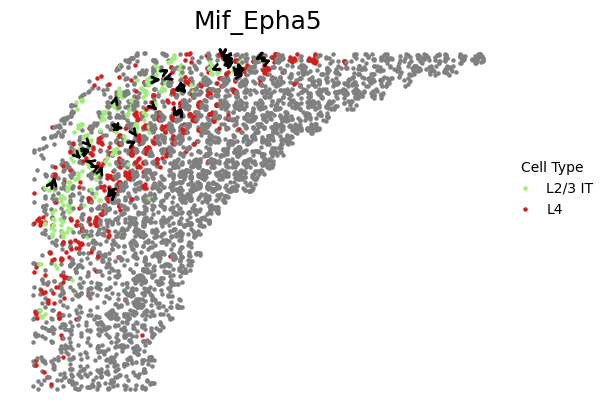

In [45]:

df = pd.read_csv('./ad_st_new.csv',index_col=0)
Sst_value = df.loc['Mif']
Sstr2_value = df.loc['Epha5']
Nodeall = np.loadtxt('./data/Mif_Epha5/CCIlist.txt',skiprows=0,dtype=str,delimiter=' ')
nodelabel = Nodeall[:,-1]
nodes = Nodeall[:,1]
nodet = Nodeall[:,2]
cell_type = list(cluster)
sourcetype = 'L2/3 IT'
targettype = 'L4'
cor_x = list(pd.DataFrame(adata_segment.obs).iloc[:, 0])
cor_y = list(pd.DataFrame(adata_segment.obs).iloc[:, 1])

score_list = []
index = []
for i in range(len(nodelabel)):
    if nodelabel[i] == '1':
        if cell_type[int(nodes[i])] == sourcetype and cell_type[int(nodet[i])] == targettype:
            score_list.append(np.sqrt(Sst_value[int(nodes[i])]*Sstr2_value[int(nodet[i])]))
sorted_list = sorted(enumerate(score_list), key=lambda x: x[1],reverse=True)[0:50]
sorted_indices = [index for index, _ in sorted_list]
sorted_values = [value for _, value in sorted_list]
print(len(sorted_list))
Ther = sorted_values[-1]
x_y_1 = []
x_y_2 = []
for i in range(len(nodelabel)):
    if nodelabel[i] == '1':
        if cell_type[int(nodes[i])] == sourcetype and cell_type[int(nodet[i])] == targettype:
            score = np.sqrt(Sst_value[int(nodes[i])] * Sstr2_value[int(nodet[i])])
            if score > Ther:
                x_y_1.append(((cor_x[int(nodes[i])]),((cor_y[int(nodes[i])]))))
                x_y_2.append(((cor_x[int(nodet[i])]),((cor_y[int(nodet[i])]))))

        
x = adata_segment.obs.y.values
y = adata_segment.obs.x.values
plt.axis('off')
for x_val, y_val, color_val,g in zip(x, y, color_list,list(cluster)):
    if g == sourcetype or g == targettype:
        plt.scatter(x_val, y_val, color=color_val,s=5,label=g)
    else:
        plt.scatter(x_val, y_val, color='gray',s=5)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
plt.legend(unique_handles,unique_labels,loc=(1,0.5),fontsize = 10,ncol = 1,frameon=False,handlelength=2, handletextpad=0.5,title='Cell Type')

#plt.legend(label,loc=(1,0.5),fontsize = 10,ncol = 1,frameon=False,handlelength=2, handletextpad=0.5,title='Cell Type')


for i in range(len(x_y_1)):
    plt.annotate("",
                 xy=x_y_2[i], xycoords='data',
                 xytext=x_y_1[i], textcoords='data',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", linewidth=2))
plt.title('Mif_Epha5', fontsize=18)
plt.gca().invert_yaxis()
plt.savefig('./fig/Mif_Epha5.pdf',bbox_inches='tight',dpi=300)

In [46]:

#Psen1_Fzd3,Dusp18_Adcy1,Psen1_Pparg
import os
df = pd.read_csv('./st_meta.csv',sep = ',',index_col=0)
max_columns = df['celltype'].values
df = pd.read_csv('./ad_st_new.csv',index_col=0)
Sst_value = df.loc['Mif']
Sstr2_value = df.loc['Epha5']
Nodeall = np.loadtxt('./data/Mif_Epha5/CCIlist.txt',skiprows=0,dtype=str,delimiter=' ')
nodelabel = Nodeall[:,-1]
nodes = Nodeall[:,1]
nodet = Nodeall[:,2]
#nodescore = Nodeall[:,3]
cell_type = list(max_columns)

unique_cell_type = list(set(cell_type))
print(unique_cell_type)
#unique_cell_type.remove('Oligo')
unique_cell_type=['L2/3_IT','L4','CR','L5_IT', 'L5_PT', 'L6_IT','L6b', 'L6_CT']
data =  np.zeros((len(unique_cell_type),len(unique_cell_type)))
#print(data.shape)

for i in range(data.shape[0]):
    #print("cells:",unique_cell_type[i])
    for j in range(data.shape[0]):
        #print("cellt:",unique_cell_type[j])
        sourcetype = unique_cell_type[i]
        targettype = unique_cell_type[j]
        score = []
        for m in range(len(nodelabel)):
            if nodelabel[m] == '1':
                if cell_type[int(nodes[m])] == sourcetype and cell_type[int(nodet[m])] == targettype:
                    score1 = np.sqrt(Sst_value[int(nodes[m])] * Sstr2_value[int(nodet[m])])
                    score.append(score1)
                else:
                    score.append(0)
            else:
                score.append(0)
        #print(score)
        score_mean =  np.mean(np.array(score).astype(np.float64))
        data[i][j] =  score_mean
data

['L6b', 'Sst', 'Macrophage', 'L4', 'Lamp5', 'L6_IT', 'L2/3_IT', 'SMC', 'Vip', 'L6_CT', 'VLMC', 'Peri', 'NP', 'L5_PT', 'Pvalb', 'Endo', 'Astro', 'L5_IT', 'Oligo', 'Sncg', 'Serpinf1']


array([[0.        , 0.03072053, 0.        , 0.002238  , 0.        ,
        0.        , 0.        , 0.        ],
       [0.03118612, 0.        , 0.        , 0.0249469 , 0.0015194 ,
        0.00327724, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00226774, 0.02511409, 0.        , 0.        , 0.00093956,
        0.00525874, 0.        , 0.00788499],
       [0.        , 0.00145721, 0.        , 0.0009023 , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.0034843 , 0.        , 0.00560992, 0.00052985,
        0.        , 0.        , 0.00692642],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00791897, 0.00046927,
        0.00668661, 0.00087129, 0.        ]])

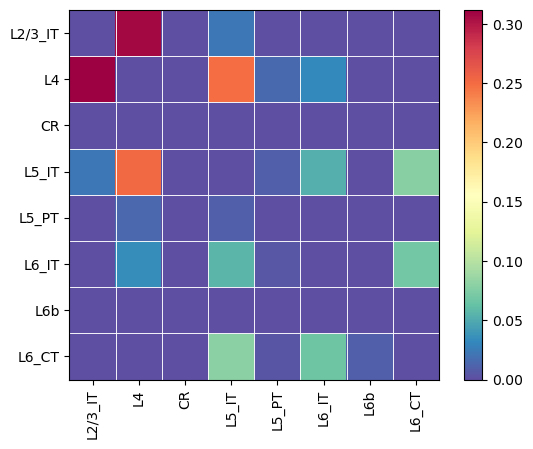

In [47]:
import numpy as np
import matplotlib.pyplot as plt
#data_filled = np.nan_to_num(data, nan=0)
'''
rows = np.any(data_filled != 0, axis=1)
cols = np.any(data_filled != 0, axis=0)
result = data_filled[rows][:, cols]
# 创建一个示例数据
#data = np.random.rand(5, 5)
'''
# 创建样本名称列表
sample_names = unique_cell_type

# 绘制热图
plt.imshow(data*10,cmap = 'Spectral_r')

num_rows, num_cols = data.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='white', linewidth=0.5, fill=False))



# 设置x轴和y轴刻度
plt.xticks(np.arange(len(sample_names)), sample_names, rotation=90)
plt.yticks(np.arange(len(sample_names)), sample_names)

# 添加颜色栏
plt.colorbar()
plt.savefig('./fig/Heatmap_Mif_Epha5.pdf',bbox_inches='tight',dpi=300)
# 显示图形
plt.show()


In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle as pkl
import os

from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

import sys


In [50]:
Cellpairall = pd.read_csv('./cell_pair_all.csv')
tool_res_dic = {}
df_new = Cellpairall[["celltype_sender","celltype_receiver","ligand","receptor","label"]]
df_new = df_new.drop_duplicates()
#print(df_new)
ligand = df_new["ligand"].values.tolist()
receptor = df_new["receptor"].values.tolist()
Sender = df_new["celltype_sender"].values.tolist()
Receiver = df_new["celltype_receiver"].values.tolist()
CCIlabel = df_new["label"].values.tolist()


for i in range(len(CCIlabel)):

    if str(CCIlabel[i]) == '1':
        CC = Sender[i] + '|' + Receiver[i]
        LR = []
        for j in range(len(CCIlabel)):
            if Sender[j]==Sender[i] and Receiver[j]== Receiver[i]:
                LR.append(ligand[j] + ' - ' + receptor[j])
        LR = list(set(LR))
        tool_res_dic.update({
            CC: LR
        })


    

In [51]:
tool_res_dic

{'Pvalb|Vip': ['Serpinc1 - Sdc2',
  'Nrg2 - Erbb4',
  'Hbegf - Erbb4',
  'Ptn - Acvr1',
  'Adam15 - Acvr1',
  'Gnai2 - Acvr1',
  'Vegfa - Bmpr1a',
  'Adam9 - Ptpra',
  'Fgf12 - Gpc1',
  'Sema4g - Plxna2',
  'Slit2 - Itgav',
  'Efna5 - Epha7',
  'Ptn - Sdc2',
  'Adam15 - Erbb4',
  'Slit2 - Sdc2',
  'Uba52 - Acvr1',
  'Gnai2 - Gpc1',
  'Nlgn2 - Ramp2',
  'Npy - Npy1r',
  'Adam15 - Pde1b',
  'Hmgb1 - Ntrk3',
  'Hbegf - Il1rap',
  'Ncan - Cnr1',
  'Ptn - Ncl',
  'Serpinc1 - Gpc1'],
 'Pvalb|Lamp5': ['Sst - Sstr2',
  'Nrg2 - Erbb4',
  'Serpinc1 - Sdc2',
  'Hbegf - Erbb4',
  'Nrxn3 - Ptprm',
  'Efna5 - Epha4',
  'Vegfa - Bmpr1a',
  'Adam9 - Ptpra',
  'Fgf12 - Gpc1',
  'Sema4g - Plxna2',
  'Ptn - Sdc2',
  'Adam15 - Erbb4',
  'Slit2 - Sdc2',
  'Fgf13 - Ifnar2',
  'Gnai2 - Gpc1',
  'Nlgn2 - Ramp2',
  'Hspa8 - Sdc2',
  'Adam15 - Pde1b',
  'Hbegf - Il1rap',
  'Sst - Sstr1',
  'Ncan - Cnr1',
  'Ptn - Ncl',
  'Gnas - Sdc2',
  'Fgf11 - Acvr1b',
  'Psen1 - Fzd3',
  'Serpinc1 - Gpc1',
  'Vegfa - Lrp6',

In [72]:
df = pd.read_csv('./st_meta.csv',sep = ',',index_col=0)
max_columns = df['celltype'].values
cell_type = list(max_columns)
dic = {}

unique_cell_type=['Vip','Lamp5','Astro','Sncg','Macrophage','NP','Sst','L4','L5_IT', 'L6_IT', 'L6_CT']
#unique_cell_type=['L4', 'L5_PT','L5_IT', 'L6_IT','L6b', 'L6_CT']

for j in range(len(unique_cell_type)):
    sourcetype = 'Pvalb'
    targettype = unique_cell_type[j]

    cellpair = 'Pvalb'+ '|' + str(unique_cell_type[j])
    print(cellpair)
    list1 = []
    for i in range(len(tool_res_dic[cellpair])):
        df = pd.read_csv('./ad_st_new.csv',index_col=0)
        L = tool_res_dic[cellpair][i].split(' - ')[0]
        R = tool_res_dic[cellpair][i].split(' - ')[1]
        Sst_value = df.loc[L]
        Sstr2_value = df.loc[R]
        LR = str(L) + '_' + str(R)
        print(LR)
        CCI_file = './data/'+ LR +'/CCIlist.txt'
        if os.path.exists(CCI_file):
            Nodeall = np.loadtxt('./data/'+ LR +'/CCIlist.txt',skiprows=0,dtype=str,delimiter=' ')
            nodelabel = Nodeall[:,-1]
            nodes = Nodeall[:,1]
            nodet = Nodeall[:,2]
            score = []
            for m in range(len(nodelabel)):
                if nodelabel[m] == '1':
                    #print(cell_type[int(nodes[m])])
                    #print(cell_type[int(nodet[m])])
                    if cell_type[int(nodes[m])] == sourcetype and cell_type[int(nodet[m])] == targettype:
                        
                        score1 = np.sqrt(Sst_value[int(nodes[m])] * Sstr2_value[int(nodet[m])])
                        
                        score.append(score1)
                    else:
                        score.append(0)
                else:
                    score.append(0)
            #print(score)
            score_mean =  np.mean(np.array(score).astype(np.float64))
        print(score_mean)
        list1.append(LR + ':' +str(score_mean))
    dic.update({
                cellpair: list1
            })
dic  

Pvalb|Vip
Serpinc1_Sdc2
0.07212523698198679
Nrg2_Erbb4
0.12888114664758887
Hbegf_Erbb4
0.27972683714519087
Ptn_Acvr1
0.0940442324682683
Adam15_Acvr1
0.08538363186280636
Gnai2_Acvr1
0.07109572529599789
Vegfa_Bmpr1a
0.08139499062030045
Adam9_Ptpra
0.07449696156996763
Fgf12_Gpc1
0.08923869079156105
Sema4g_Plxna2
0.07550656396438116
Slit2_Itgav
0.1171889064412194
Efna5_Epha7
0.07426386332125563
Ptn_Sdc2
0.08217856759099043
Adam15_Erbb4
0.14376065268166655
Slit2_Sdc2
0.17609342398826489
Uba52_Acvr1
0.08141972842555188
Gnai2_Gpc1
0.07062731694690572
Nlgn2_Ramp2
0.08420326297458616
Npy_Npy1r
0.17988849074702817
Adam15_Pde1b
0.07965452793238244
Hmgb1_Ntrk3
0.08586690517188485
Hbegf_Il1rap
0.15142104240674845
Ncan_Cnr1
0.08190149632223727
Ptn_Ncl
0.08640473752878332
Serpinc1_Gpc1
0.08603946374434931
Pvalb|Lamp5
Sst_Sstr2
0.032670417836322574
Nrg2_Erbb4
0.06270358627707996
Serpinc1_Sdc2
0.043232690081376396
Hbegf_Erbb4
0.13834701948125558
Nrxn3_Ptprm
0.08051395216155789
Efna5_Epha4
0.03796930665

Calm3_Lifr
0.03778067570804974
Vegfa_Lrp6
0.045817445971016606
Rbp4_Lrp6
0.045869536479860765
Hsp90b1_Gfra4
0.033654384479505105
Pvalb|L6_IT
Sst_Sstr2
0.014020569343670474
Serpinc1_Sdc2
0.01395853567089526
Edil3_Efna5
0.011856182895662702
Gnai2_Acvr1b
0.00940875874231495
Ptn_Acvr1
0.013649410859877621
Calm1_Itgav
0.018926444171421468
Gnai2_Igf1r
0.00980455872670544
Tln1_Bmpr1a
0.009797137868761619
Efnb2_Chrm3
0.008965345398631263
Adam15_Acvr1
0.01165716465919554
Gnai2_Acvr1
0.010224009065603544
Hmgb1_Itgav
0.016784281483899686
Efna5_Epha4
0.01712915049037272
Vegfa_Bmpr1a
0.012695249851510692
Efnb2_Epha4
0.010659910862305498
Adam9_Ptpra
0.00983163903098925
Fgf12_Gpc1
0.012892706802669544
Rims1_Slc17a7
0.02397974666748174
Sema4g_Plxna2
0.017544133766758535
Slit2_Itgav
0.04825016479882188
Efna5_Epha7
0.013684657395532259
Psen1_Gfra2
0.0205606867262798
Ptn_Sdc2
0.016976057482472166
Slit2_Sdc2
0.037389405099404714
Uba52_Acvr1
0.011644767846146464
Fgf13_Ifnar2
0.012252264687995534
Plxna2_Neo

{'Pvalb|Vip': ['Serpinc1_Sdc2:0.07212523698198679',
  'Nrg2_Erbb4:0.12888114664758887',
  'Hbegf_Erbb4:0.27972683714519087',
  'Ptn_Acvr1:0.0940442324682683',
  'Adam15_Acvr1:0.08538363186280636',
  'Gnai2_Acvr1:0.07109572529599789',
  'Vegfa_Bmpr1a:0.08139499062030045',
  'Adam9_Ptpra:0.07449696156996763',
  'Fgf12_Gpc1:0.08923869079156105',
  'Sema4g_Plxna2:0.07550656396438116',
  'Slit2_Itgav:0.1171889064412194',
  'Efna5_Epha7:0.07426386332125563',
  'Ptn_Sdc2:0.08217856759099043',
  'Adam15_Erbb4:0.14376065268166655',
  'Slit2_Sdc2:0.17609342398826489',
  'Uba52_Acvr1:0.08141972842555188',
  'Gnai2_Gpc1:0.07062731694690572',
  'Nlgn2_Ramp2:0.08420326297458616',
  'Npy_Npy1r:0.17988849074702817',
  'Adam15_Pde1b:0.07965452793238244',
  'Hmgb1_Ntrk3:0.08586690517188485',
  'Hbegf_Il1rap:0.15142104240674845',
  'Ncan_Cnr1:0.08190149632223727',
  'Ptn_Ncl:0.08640473752878332',
  'Serpinc1_Gpc1:0.08603946374434931'],
 'Pvalb|Lamp5': ['Sst_Sstr2:0.032670417836322574',
  'Nrg2_Erbb4:0.06

In [73]:
# 找到字典中所有数的最大的5个数
max_values = sorted([float(v.split(':')[1]) for sublist in dic.values() for v in sublist], reverse=True)[:50]

# 生成新的字典，只保留最大5个数的值
new_data = {k: [v for v in sublist if float(v.split(':')[1]) in max_values] for k, sublist in dic.items()}

# 打印新的字典
print(new_data)

{'Pvalb|Vip': ['Nrg2_Erbb4:0.12888114664758887', 'Hbegf_Erbb4:0.27972683714519087', 'Ptn_Acvr1:0.0940442324682683', 'Adam15_Acvr1:0.08538363186280636', 'Vegfa_Bmpr1a:0.08139499062030045', 'Adam9_Ptpra:0.07449696156996763', 'Fgf12_Gpc1:0.08923869079156105', 'Sema4g_Plxna2:0.07550656396438116', 'Slit2_Itgav:0.1171889064412194', 'Efna5_Epha7:0.07426386332125563', 'Ptn_Sdc2:0.08217856759099043', 'Adam15_Erbb4:0.14376065268166655', 'Slit2_Sdc2:0.17609342398826489', 'Uba52_Acvr1:0.08141972842555188', 'Nlgn2_Ramp2:0.08420326297458616', 'Npy_Npy1r:0.17988849074702817', 'Adam15_Pde1b:0.07965452793238244', 'Hmgb1_Ntrk3:0.08586690517188485', 'Hbegf_Il1rap:0.15142104240674845', 'Ncan_Cnr1:0.08190149632223727', 'Ptn_Ncl:0.08640473752878332', 'Serpinc1_Gpc1:0.08603946374434931'], 'Pvalb|Lamp5': ['Hbegf_Erbb4:0.13834701948125558', 'Nrxn3_Ptprm:0.08051395216155789', 'Slit2_Sdc2:0.10180666704682709', 'Hbegf_Il1rap:0.10525937602014349'], 'Pvalb|Astro': [], 'Pvalb|Sncg': [], 'Pvalb|Macrophage': [], 'Pval

In [74]:
import pandas as pd
import numpy as np


df = pd.DataFrame([(key, value) for key, values in new_data.items() for value in values], columns=['key', 'value'])
df[['column', 'data']] = df['value'].str.split(':', 1, expand=True)
df = df.pivot(index='key', columns='column', values='data')
df.columns.name = None

df = df.fillna(0)  # 将NaN值替换为0

print(df)

                    Adam15_Acvr1         Adam15_Erbb4         Adam15_Pde1b  \
key                                                                          
Pvalb|L4                       0                    0                    0   
Pvalb|L5_IT                    0                    0                    0   
Pvalb|Lamp5                    0                    0                    0   
Pvalb|Sst                      0                    0                    0   
Pvalb|Vip    0.08538363186280636  0.14376065268166655  0.07965452793238244   

                     Adam9_Ptpra            B2m_Itgav          Calm1_Itgav  \
key                                                                          
Pvalb|L4                       0  0.08686121568449111  0.09191429490697833   
Pvalb|L5_IT                    0                    0                    0   
Pvalb|Lamp5                    0                    0                    0   
Pvalb|Sst                      0                    0          

In [75]:
data

array([[0.05400843, 0.04889775, 0.05696863, 0.05337863, 0.08686122,
        0.09191429, 0.09241327, 0.05128108, 0.0628022 , 0.0870208 ,
        0.05440228, 0.05219989, 0.07911444, 0.09111322, 0.05412956,
        0.12669537, 0.08150897, 0.05426314, 0.10430839, 0.05467879,
        0.09724562, 0.07262756, 0.06976398, 0.10337505, 0.05699753,
        0.06189901, 0.05414817, 0.05710535, 0.06439353, 0.09925664,
        0.07122162, 0.0492517 , 0.21561275, 0.11359238, 0.10074702,
        0.05124751, 0.06621523],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04864017, 0.        , 0.        , 0.05233118,
        0.        , 0.        , 0.05678513, 0.        , 0.        ,
        0.07402876, 0.        , 0.        , 0.06471657, 0.        ,
        0.05728414, 0.049518  , 0.        , 0.06098854, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.06719552,
        0.04920595, 0.        , 0.11838882, 0.09703586, 0.04975447,
        0.     

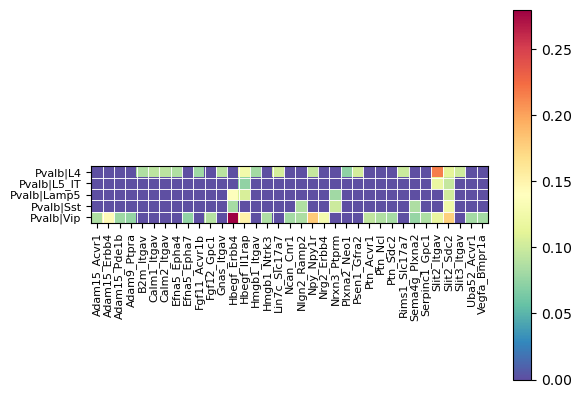

In [77]:
import numpy as np
import matplotlib.pyplot as plt
#data_filled = np.nan_to_num(data, nan=0)
'''
rows = np.any(data_filled != 0, axis=1)
cols = np.any(data_filled != 0, axis=0)
result = data_filled[rows][:, cols]
# 创建一个示例数据
#data = np.random.rand(5, 5)
'''
# 创建样本名称列表

data =  np.array(df.values).astype(float)

# 绘制热图
plt.imshow(data,cmap = 'Spectral_r')

num_rows, num_cols = data.shape
for i in range(num_rows):
    for j in range(num_cols):
        plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, edgecolor='white', linewidth=0.5, fill=False))



# 设置x轴和y轴刻度
plt.xticks(np.arange(len(df.columns)), df.columns, rotation=90,fontsize=8, ha='center')
plt.yticks(np.arange(len(df.index)), df.index, fontsize=8)

# 添加颜色栏
plt.colorbar()
plt.savefig('./fig/Heatmap_all.pdf',bbox_inches='tight',dpi=300)
# 显示图形
plt.show()
